In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import cv2
import glob
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/MelNev/test.zip
!unzip /content/drive/MyDrive/MelNev/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/nevus/ISIC_0068320.jpg  
  inflating: train/nevus/ISIC_0030934.jpg  
  inflating: train/nevus/ISIC_0030997.jpg  
  inflating: train/nevus/ISIC_0031079.jpg  
  inflating: train/nevus/ISIC_0031148.jpg  
  inflating: train/nevus/ISIC_0031149.jpg  
  inflating: train/nevus/ISIC_0031281.jpg  
  inflating: train/nevus/ISIC_0031308.jpg  
  inflating: train/nevus/ISIC_0031395.jpg  
  inflating: train/nevus/ISIC_0031405.jpg  
  inflating: train/nevus/ISIC_0031440.jpg  
  inflating: train/nevus/ISIC_0031451.jpg  
  inflating: train/nevus/ISIC_0031572.jpg  
  inflating: train/nevus/ISIC_0031654.jpg  
  inflating: train/nevus/ISIC_0031675.jpg  
  inflating: train/nevus/ISIC_0031683.jpg  
  inflating: train/nevus/ISIC_0031699.jpg  
  inflating: train/nevus/ISIC_0031726.jpg  
  inflating: train/nevus/ISIC_0031775.jpg  
  inflating: train/nevus/ISIC_0031813.jpg  
  inflating: train/nevus/ISIC_0031826.jpg  
  inflating: train/nevus/

In [ ]:
data_dir_train = pathlib.Path("train") # путь к изобраениям для тренировки
data_dir_test = pathlib.Path("test") # путь к изобраениям для теста
dir_path = os.getcwd() # корневой путь

### Подготовка данных и использование первой модели


In [ ]:
batch_size = 16 # размер батча, то есть сколько иозбражений бодет подаваться модели на вхоодной слой
# размер изображения для обучения
img_height = 224
img_width = 224

In [ ]:
# используем tensorflow для создания препроцессовой выборки для тренировки
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2, # для валидации оставляем 20% от тренировочной выборки
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 13961 files belonging to 2 classes.
Using 11169 files for training.


In [ ]:
# то же самое для валидации
# https://habr.com/ru/articles/458170/ здесь можно почитать, зачем нужны валидационные данные в процессе обучения
# если коротко, они помогают модели не переобучаться
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 13961 files belonging to 2 classes.
Using 2792 files for validation.


In [ ]:
# то же самое для теста
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2429 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names) # посмотрим на наши названия классов, они равны названим папок с изображениями

['melanoma', 'nevus']


In [ ]:
# Преобразование кэша может кэшировать набор данных либо в памяти, либо в локальном хранилище.
# Это позволит избежать выполнения некоторых операций (например, открытия файлов и чтения данных) в каждую эпоху.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:

class WrappedDataGenerator:
    def __init__(self, dataset, batch_size, subset_size=None):
        self.dataset = dataset
        self.batch_size = batch_size if batch_size is not None else 16
        self.subset_size = subset_size if subset_size is not None else len(dataset)
        self.data = []
        self.labels = []
        for images, labels in dataset.take(self.subset_size // self.batch_size):
            self.data.append(images.numpy())
            self.labels.append(labels.numpy().reshape(-1, 1))
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)

    def __len__(self):
        num_batches = 0
        for _ in self.dataset:
            num_batches += 1
        return num_batches

    def __getitem__(self, idx):
        for i, (x_batch, y_batch) in enumerate(self.dataset):
            if i == idx:
                return x_batch.numpy(), y_batch.numpy().reshape(-1, 1)
        raise IndexError

def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=len(class_names))
    return image, label

subset_size_train = 1000  # Например, берем первые 1000 образцов
subset_size_val = 200

def load_data(batch_size):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        validation_split=0.2, # для валидации оставляем 20% от тренировочной выборки
        subset="training",
        label_mode='binary',
        seed=123,
        image_size = (img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        validation_split=0.2,
        subset="validation",
        label_mode='binary',
        seed=123,
        image_size = (img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )
    return train_ds, val_ds

default_batch_size = 16

train_ds2, val_ds2 = load_data(default_batch_size)

class_names = train_ds2.class_names
num_classes = len(class_names)

# Применение функции one_hot_encode к каждому элементу датасета
# train_ds2 = train_ds2.map(one_hot_encode)
# val_ds2 = val_ds2.map(one_hot_encode)


# Обертка для тренировочного и валидационного наборов данных
train_gen = WrappedDataGenerator(train_ds2, batch_size=default_batch_size, subset_size=subset_size_train)
val_gen = WrappedDataGenerator(val_ds2, batch_size=default_batch_size, subset_size=subset_size_val)

def dataset_to_numpy(dataset, batch_size=16, subset_size=None):
    data = []
    labels = []
    for images, labels_ in dataset:
        data.append(images.numpy())
        labels.append(labels_.numpy().reshape(-1, 1))
        if subset_size is not None and len(data) * batch_size >= subset_size:
            break
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    return data, labels


Found 13961 files belonging to 2 classes.
Using 11169 files for training.
Found 13961 files belonging to 2 classes.
Using 2792 files for validation.


In [ ]:
def create_simple_model(neurons,filters,optimizer='rmsprop'):
    model = Sequential([
        layers.Conv2D(filters, 3, padding='same', activation='relu'),
        layers.Conv2D(filters, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        # layers.GlobalAveragePooling2D(),
        layers.Dense(neurons, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Упрощенная модель для поиска гиперпараметров
model = KerasClassifier(build_fn=create_simple_model, neurons=32, filters=32, epochs=10, batch_size=16, verbose=0)

# Определение параметров для случайного поиска
param_dist = {
    'optimizer': ['rmsprop', 'adam'],
    'neurons': [32, 64, 128],
    'filters': [32, 64, 128],
    'batch_size': [16]
}


X_train, y_train = dataset_to_numpy(train_ds2, batch_size, subset_size_train)
X_val, y_val = dataset_to_numpy(val_ds2, batch_size, subset_size_val)

# print(X_val)
# Случайный поиск с подвыборкой данных
print(model.get_params().keys())
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, n_jobs=-1, cv=3)
random_search_result = random_search.fit(X_train, y_train, validation_data=(X_val, y_val))

print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")

# # Теперь используем лучшие найденные параметры для полной модели
# best_params = random_search_result.best_params_
# full_model = create_simple_model(optimizer=best_params['optimizer'], neurons=best_params['neurons'])
# full_model.fit(train_ds2, epochs=10, batch_size=best_params['batch_size'], validation_data=val_gen)

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'neurons', 'filters', 'class_weight'])


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_1' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_4' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_5' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_6' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_7' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_8' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_9' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_10' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_11' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_12' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_13' has no defined outputs yet.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_14' has no defined outputs yet.


In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height,
                                img_width,
                                3)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical", seed=123),
    layers.RandomRotation(factor=(-0.4, 0.4)),
    layers.RandomZoom(0.5),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])


In [ ]:
# компилируем модель
# задаем оптимизатор adam
# loss - потери у нас вычисляются по формуле кроссэтропии
# метрика - accyracy (точность = количество правильных предсказаний / все предсказания)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_6 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_7 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,383,778 (100.65 MB)

 Trainable params: 26,383,586 (100.65 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
import gc
gc.collect()

2557

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
epochs = 10 # сколько эпох будет обучаться
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 373s 382ms/step - accuracy: 0.5172 - loss: 4.5995 - val_accuracy: 0.5217 - val_loss: 0.6923
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 206s 341ms/step - accuracy: 0.5231 - loss: 0.6922 - val_accuracy: 0.5217 - val_loss: 0.6922
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 193s 341ms/step - accuracy: 0.5225 - loss: 0.7022 - val_accuracy: 0.4429 - val_loss: 0.6982
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 197s 349ms/step - accuracy: 0.5972 - loss: 0.6821 - val_accuracy: 0.6739 - val_loss: 0.6113
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 197s 348ms/step - accuracy: 0.6561 - loss: 0.6351 - val_accuracy: 0.7071 - val_loss: 0.6037
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 197s 348ms/step - accuracy: 0.6880 - loss: 0.5914 - val_accuracy: 0.6956 - val_loss: 0.5344
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 197s 348ms/step - accuracy: 0.7260 - loss: 0.5504 - val_accuracy: 0.7142 - val_loss: 0.5260
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 203s 350ms/step - accuracy: 0.7324 -

In [ ]:
#model = keras.models.load_model('')

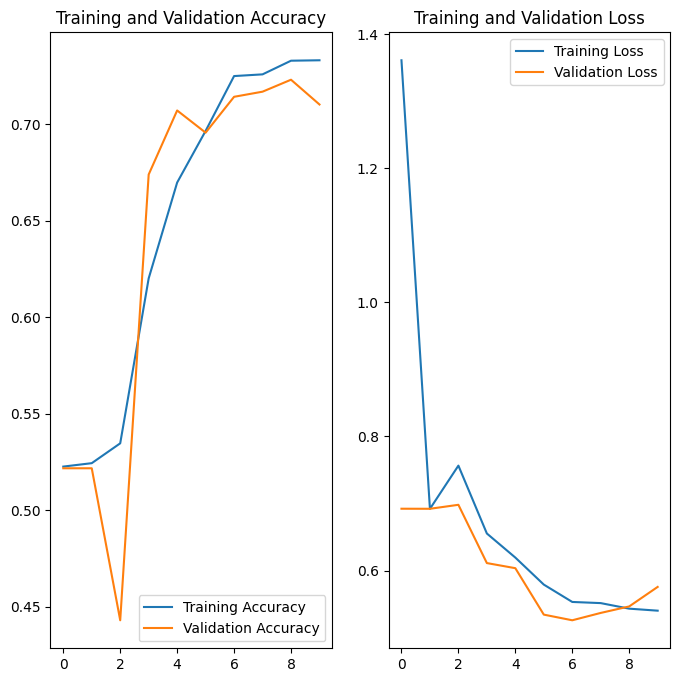

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model.evaluate(test_ds)

169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.7299 - loss: 0.5642


[0.566591203212738, 0.7232540845870972]

In [ ]:
model.save('model-72.keras')

In [ ]:
trained_model = tf.keras.models.load_model("model-72.keras")

In [ ]:
trained_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

In [ ]:
epochs = 5 # сколько эпох будет обучаться
history = trained_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 266s 376ms/step - accuracy: 0.7163 - loss: 0.5459 - val_accuracy: 0.7282 - val_loss: 0.5797
Epoch 2/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 234s 335ms/step - accuracy: 0.7260 - loss: 0.5348 - val_accuracy: 0.7475 - val_loss: 0.5082
Epoch 3/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 235s 336ms/step - accuracy: 0.7268 - loss: 0.5577 - val_accuracy: 0.7217 - val_loss: 0.5204
Epoch 4/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 235s 336ms/step - accuracy: 0.7295 - loss: 0.5337 - val_accuracy: 0.7525 - val_loss: 0.5127
Epoch 5/5
699/699 ━━━━━━━━━━━━━━━━━━━━ 263s 337ms/step - accuracy: 0.7369 - loss: 0.5244 - val_accuracy: 0.7629 - val_loss: 0.5242


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
test_predictions = np.argmax(trained_model.predict(test_ds), axis=-1)

152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step


In [ ]:
for x, y in test_ds:
    x_, y_ = x, y
    break

In [ ]:
np.argmax(trained_model.predict(x_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


12

In [ ]:
trained_model.predict(x_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


array([[0.96168876, 0.03831129],
       [0.5510006 , 0.44899938],
       [0.37290266, 0.6270973 ],
       [0.1289689 , 0.8710311 ],
       [0.2788572 , 0.7211428 ],
       [0.78473806, 0.2152619 ],
       [0.9893209 , 0.01067917],
       [0.39367235, 0.60632765],
       [0.34388188, 0.6561181 ],
       [0.22426705, 0.775733  ],
       [0.85806227, 0.1419377 ],
       [0.15056044, 0.84943956],
       [0.71998644, 0.2800136 ],
       [0.45117798, 0.54882205],
       [0.6843384 , 0.31566155],
       [0.7438608 , 0.25613922]], dtype=float32)

In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
    for i in range(len(x)):
        print(np.argmax(trained_model.predict(x)))
        prediction_classes = np.concatenate([prediction_classes,
                            np.argmax(trained_model.predict(x[i]))])
        true_classes = np.concatenate([true_classes, y[i].numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
30


KeyboardInterrupt: 

In [ ]:
report = classification_report(test_labels, test_predictions)

In [ ]:
report.

'              precision    recall  f1-score   support\n\n           0       0.48      0.53      0.51      1159\n           1       0.53      0.49      0.51      1270\n\n    accuracy                           0.51      2429\n   macro avg       0.51      0.51      0.51      2429\nweighted avg       0.51      0.51      0.51      2429\n'